# Homework 6
This homework builds on the effective visualization workshop with the Star Trek data. Below is what we completed in class. Output is suppressed for readability, but you can remove the supression on your code if you'd like.

In [4]:
invisible({
suppressPackageStartupMessages(library(tidyverse))

# Get the data.
dialogs <- read_csv(
  "https://raw.githubusercontent.com/Vincent-Toups/bios512/fcbc65a2696c7cff80d0f6ed1dd5c97abf0ef800/effective-visualization/source_data/tng.csv",
  show_col_types = FALSE
)
head(dialogs, 10) # Showing first 10 observations

# Checkout the data.
names(dialogs)
dialogs %>% group_by(character) %>% tally() %>% arrange(desc(n))
dialogs %>% mutate(dialog_length=str_length(dialog)) %>% group_by(character) %>% summarize(mean_dialog_length = mean(dialog_length)) %>% arrange(desc(mean_dialog_length))

# Fix weird data.
dialogs %>% filter(character=="BEVERLY'S")

dialogs_fixed <- dialogs %>%
  mutate(
    character = str_replace_all(character, "'S.*$", ""),
    character = str_replace_all(character, " VOICE", ""),
    character = str_replace_all(character, "\\.", ""),
    character = str_replace_all(character, "'", ""),
    character = str_replace_all(character, "S COM", ""),
    character = str_replace_all(character, " COM", ""),
    dialog_length = str_length(dialog)
  ) %>%
  filter(character %in% unlist(str_split("PICARD RIKER DATA TROI BEVERLY WORF WESLEY GEORDI", " ")))

dialogs_fixed %>% group_by(character) %>% summarize(mean_dialog_length = mean(dialog_length), std_dialog_length=sd(dialog_length)) %>% arrange(desc(mean_dialog_length))

dialog_len_per_ep <- dialogs_fixed %>% group_by(character, episode_number) %>% summarize(mean_dialog_length = mean(dialog_length), std_dialog_length=sd(dialog_length), .groups = "drop") %>% arrange(desc(mean_dialog_length))

dialog_len_per_ep

# Plot the data.
ggplot(dialogs_fixed) + geom_density(aes(x=dialog_length))

for_factor <- dialog_len_per_ep %>% group_by(character) %>% summarise(m=mean(mean_dialog_length)) %>% arrange(desc(m))
ggplot(dialog_len_per_ep, aes(factor(character,for_factor$character), mean_dialog_length)) + geom_boxplot()

dialog_len_per_ep <- dialogs_fixed %>% 
    group_by(character, episode_number) %>% 
    summarize(mean_dialog_length = mean(dialog_length), dialog_count=n(), .groups = "drop") %>% 
    arrange(desc(mean_dialog_length))

ggplot(dialog_len_per_ep, aes(dialog_count, mean_dialog_length)) + geom_point(aes(color=character)) + facet_wrap(~character)
})

## Question 1
In class, we left off on the plot below, which shows the distribution of dialog count by mean dialog length, where each point represents an episode. Interpret these results. How can we tell the character's role in the story by their plot?

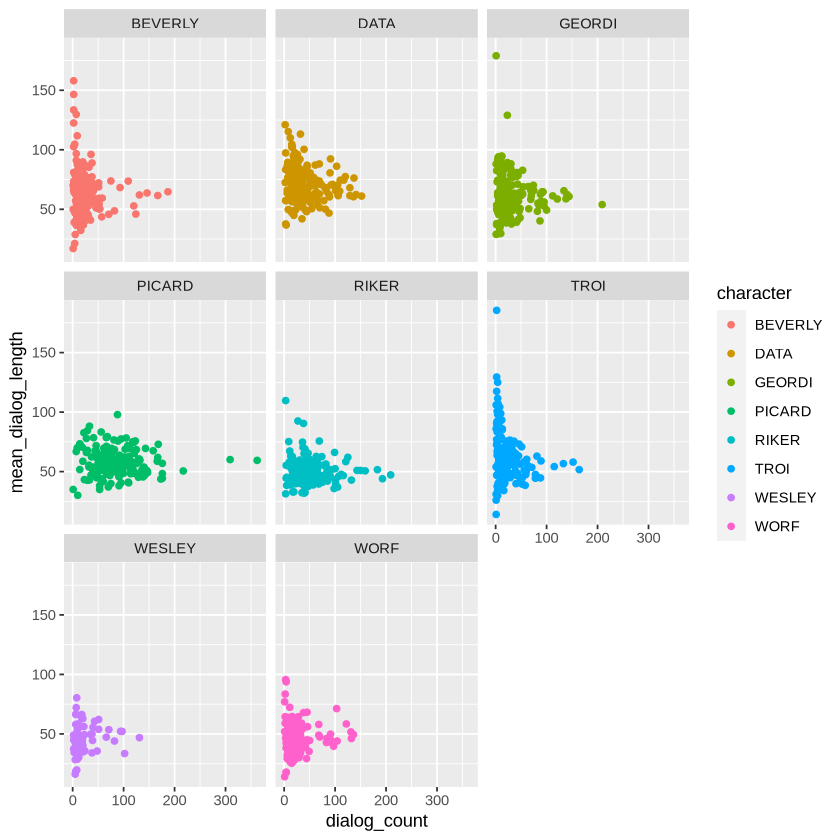

In [6]:
ggplot(dialog_len_per_ep, aes(dialog_count, mean_dialog_length)) + 
    geom_point(aes(color=character)) + 
    facet_wrap(~character)

##### Picard, Data, Riker, and Geordi appear to have a more elongated plot in their data which would mean they speak frequently and they speak for a decent amount of time. Troi and Beverly seem to have a tighter cluster of points on the dialog count axis but it stretches in length across the mean dialog length suggesting that they do not speak as often but they so speak for a longer time while Wesley and Worf have tight clusters that do not extend far along either axis so they do not talk much or for a long amount of time. With this visualization we can see that the main characters are Picard, Data, Riker, and Geordi, with supporting characters Beverly and Troi, and the small supporting characters are Wesley and Worf.

## Question 2
#### a) Compare Beverly's mean dialog per episode vs. mean dialog count per episode from season 1 (episodes 102-126) to season 3 (episodes 149-174) in a table.  
*Hints*:  
-   First, use `filter()` to get - 1) the dialog from only Beverly's character and 2) the episodes within the ranges given.
-   Then, add a season variable using `mutate()` with `case_when()`.
-   To create the means per episode, after your `mutate()` step, you'll need to `group_by()` season and episode number, then you can do your `summarize()` step to get the means by episode. At the end of the `summary()` statement (inside the parenthesis), add `.groups="drop"`. 
-   Then, to get the mean of means, you'll do the same as above, but only grouping by season. 

In [11]:
beverly <- dialogs_fixed %>% filter(
    character == "BEVERLY")
beverly_seasons <- beverly %>% mutate(
    season = case_when(
        episode_number >= 102 & episode_number <= 126 ~ "Season 1",
        episode_number >= 149 & episode_number <= 174 ~ "Season 3",
        TRUE ~ NA_character_
        )
    ) %>% filter(
    !is.na(season)) %>% group_by(
    season, episode_number) %>% summarize(
    mean_length = mean(dialog_length),
    mean_count = n(),
    .groups = "drop"
    )
beverly_seasons %>% group_by(
    season) %>% summarize(
    Avg_Dialog_Length = mean(mean_length),
    Avg_Dialog_Count = mean(mean_count),
    .groups = "drop"
    )


season,Avg_Dialog_Length,Avg_Dialog_Count
<chr>,<dbl>,<dbl>
Season 1,56.48460,25.40
Season 3,67.04817,19.64


#### b) In class, we talked about this character saying the actress has stated that after she was fired and rehired, the writers began giving her storylines that made her feel like a male character. How is this reflected in our table?

##### In season 1 her lines were  a lot shorter but the amount of lines was higher than season 3. This can suggest that she did not have a substantial storyline because she more than likely did not contribute much with her short lines. In season three her average dialog length increased significantly which shows that she contributed more of a storyline though she did not have as many lines in total.

## Question 3
Let's compare the vocabulary richness (unique words / total words) of each character. 
#### a) Tokenize dialog into words, remove punctuation, convert to lowercase. Then filter out the stop words in the list below (from https://gist.github.com/sebleier/554280).
*Hint*: Here's a template for that this step should look like:
```
tokens <- YOUR_DATASET %>%
  # Split each dialog into words
  mutate(word_list = str_split(DIALOG_COLUMN, "\\s+")) %>%
  
  # Unnest the list column so each word is a row
  unnest(word_list) %>%
  
  # Clean words
  mutate(
    word = str_remove_all(word_list, "[[:punct:]]"),  # Remove punctuation
    word = str_to_lower(word)                         # Convert to lowercase
  ) %>%
  
  # Remove empty strings and stopwords
  filter(word != "", !word %in% STOPWORDS)
```

In [14]:
stop_words <- c(
  "i","me","my","myself","we","our","ours","ourselves","you","your","yours","yourself",
  "yourselves","he","him","his","himself","she","her","hers","herself","it","its","itself",
  "they","them","their","theirs","themselves","what","which","who","whom","this","that",
  "these","those","am","is","are","was","were","be","been","being","have","has","had",
  "having","do","does","did","doing","a","an","the","and","but","if","or","because","as",
  "until","while","of","at","by","for","with","about","against","between","into","through",
  "during","before","after","above","below","to","from","up","down","in","out","on","off",
  "over","under","again","further","then","once","here","there","when","where","why","how",
  "all","any","both","each","few","more","most","other","some","such","no","nor","not",
  "only","own","same","so","than","too","very","s","t","can","will","just","don","should","now"
)

tokens <- dialogs_fixed %>% mutate(
    word_list = str_split(
        dialog, "\\s+")) %>% unnest(
    word_list) %>% mutate(
    word = str_remove_all(word_list, "[[:punct:]]"),
    word = str_to_lower(word)) %>% filter(
    word != "", !word %in% stop_words)
    

#### b) Count unique words per character. Print a summary table with the following columns: character, total words, unique words, and vocabulary richness.  
*Hint*: Group by character, then use `summarize()` to get what you want. You'll use `n_distinct()` to get the unique word counts. Arrange in descending value of vocabulary richness.

In [17]:
vocab_summary <- tokens %>% group_by(
    character) %>% summarize(
    total_words = n(),
    unique_words = n_distinct(word),
    vocab_richness = unique_words / total_words,
    .groups = "drop") %>%
arrange(
    desc(vocab_richness))
vocab_summary

character,total_words,unique_words,vocab_richness
<chr>,<int>,<int>,<dbl>
WESLEY,7601,2291,0.3014077
WORF,18820,4318,0.2294368
TROI,19450,4187,0.2152699
BEVERLY,22900,4875,0.2128821
DATA,45462,8593,0.1890150
GEORDI,31978,5465,0.1708987
RIKER,41827,6458,0.1543979
PICARD,79214,9272,0.1170500


#### c) Plot total words versus vocab richness. 
-   Use the character names as the "points".
    -   *Hint*: Use `geom_text()` to add the character names as the points.
-   Do not include a legend.
    -   *Hint*: Use `theme()` to remove the legend.
-   Add a title and axis titles.
    -   *Hint*: Use `labs()` to add titles.

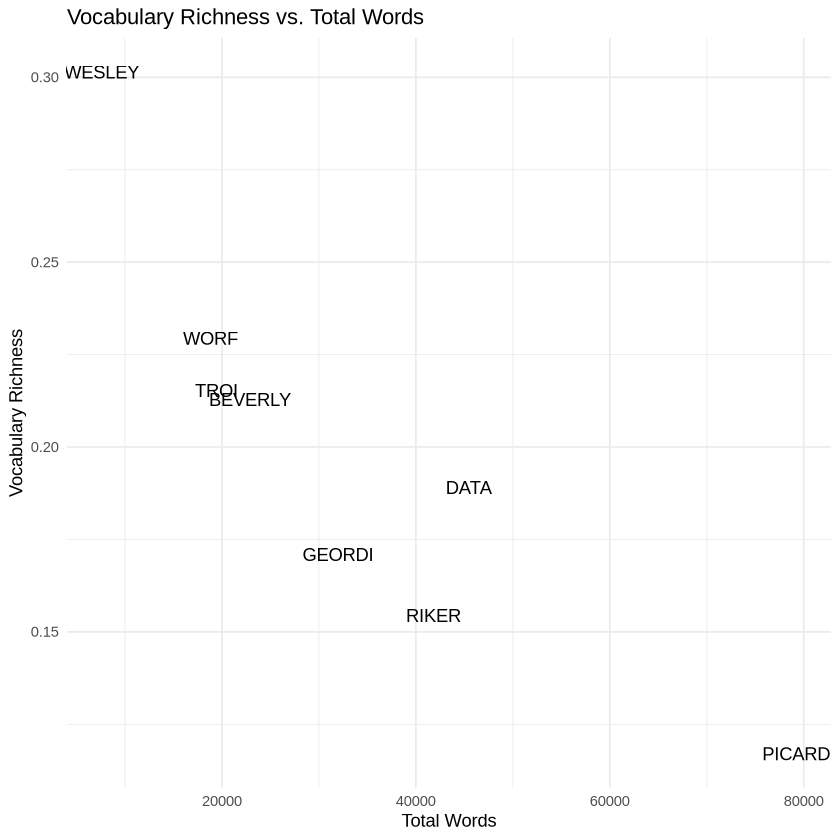

In [20]:
ggplot(vocab_summary, aes(total_words, vocab_richness, label=character)) + 
geom_text() + labs(
    title = "Vocabulary Richness vs. Total Words",
    x= "Total Words", y= "Vocabulary Richness") + theme_minimal() + theme(
    legend.position="none")

#### d) Interpret these results. 

##### Data, Troi, Beverly, and Worf all have a moderate amount of vocabulary richness and speak a decent amount of lines which reflects that they are small leads to supporting chanracters and they othen introduce unique technical or specialized language. Geordi, Riker, and Picard are more lead roles and they ten to speak more frequently which leads to them repeating words more often. The outlier in this plot is Wesley because he speaks the least total words but has the most vocabulary richness which is again because he does not appear in the show as frequently and introduces technical and specialized language.

## Question 4
#### a) Find what episode Wesley left the show as a main character and state it explicitly. Meaning, find the first significant gap where he is not found in more than two episodes in a row. 
*Hint*: It's after season 3 (ended at episode 174), so you can filter out seasons 1-3 and print Wesley's dialog count per episode. Then, scan the table for the gap. 

In [27]:
Wesley_dialog <- dialogs_fixed %>% filter(character == "WESLEY") %>% mutate(
    season = case_when(
        episode_number >= 102 & episode_number <= 126 ~ 1,
        episode_number >= 127 & episode_number <= 148 ~ 2,
        episode_number >= 149 & episode_number <= 174 ~ 3,
        episode_number >= 175 & episode_number <= 200 ~ 4,
        episode_number >= 201 & episode_number <= 226 ~ 5,
        episode_number >= 227 & episode_number <= 252 ~ 6,
        episode_number >= 253 & episode_number <= 278 ~7,
        TRUE ~ NA_real_
        ))

Wesley_per_ep <- Wesley_dialog %>% group_by(
    season, episode_number) %>% summarize(
    dialog_count = n(),
    mean_dialog_length = mean(dialog_length),
    .groups = "drop") %>%
arrange(
    season, episode_number)

wesley_after_s3 <- Wesley_per_ep %>% filter(
    season >= 4)
wesley_after_s3

season,episode_number,dialog_count,mean_dialog_length
<dbl>,<dbl>,<int>,<dbl>
4,175,18,36.38889
4,176,6,66.50000
4,177,9,53.55556
4,178,6,18.66667
4,179,38,49.97368
4,181,2,45.00000
4,183,94,52.17021
5,206,131,46.90076
5,219,71,53.56338


##### Wesley leaves the show after Season 4 episode 183. There is a significant gap between season 4 episode 183 and season 5 episode 206.

#### b) After Wesley leaves the main cast, in which episodes does he make cameo appearances?

In [29]:
wesley_cameos <- Wesley_per_ep %>% filter(
    season >=4, episode_number >183, dialog_count >0)
wesley_cameos

season,episode_number,dialog_count,mean_dialog_length
<dbl>,<dbl>,<int>,<dbl>
5,206,131,46.90076
5,219,71,53.56338
7,263,18,66.33333
7,272,97,52.09278


##### Welsey makes cameo appearences in Episodes 206, 219, 263 and 272 after his main cast departure.

#### c) Dig back into the data. Print:
-   Wesley's last piece of dialog before he left the main cast.
-   Wesley's last piece of dialog ever.  
  
*Hint*: To do this, you'll need to filter the `dialogs_fixed` data set to Welsey's lines and the episode number, and use `slice_tail(n = 1)` to get the last observation.

In [32]:
Wesley_dialog %>% filter(
    episode_number == 183) %>% slice_tail(
    n = 1)

Wesley_dialog %>% filter(
    episode_number == max(Wesley_dialog$episode_number)) %>% slice_tail(
    n = 1)

episode_number,character,dialog,dialog_length,season
<dbl>,<chr>,<chr>,<int>,<dbl>
183,WESLEY,I can walk.,11,4


episode_number,character,dialog,dialog_length,season
<dbl>,<chr>,<chr>,<int>,<dbl>
272,WESLEY,"Good-bye, Mom.",14,7


##### Wesley's last line as a main cast member is "I can walk." and his last line ever was "Good-by, Mom.".

## Question 5
Create a heatmap with `dialog_len_per_ep` showing mean dialog length per episode for each character. Sort the characters on the y-axis by their overall mean dialog length, with the lowest on top using a factor. Add a title and an axis title. 
*Hints*:
For the factor:
1. Compute overall mean (mean of mean) dialog length per character (`group_by()` then `summarize()`), and arrange the overall mean in ascending order. Add `pull(character)` to the end of this step so that you can use character as a factor in the next step. Store all of this in a new tibble.
2. Convert character to factor with this order. On `dialog_len_per_ep`, you'll use a mutate statement to add the factor `(mutate(character = factor(character, levels = DATAFROMHINT1))`.
3. Create heatmap using `geom_tile()`.
4. If you want nicer colors, you can add `scale_fill_viridis_c()` (or another color scale) to your ggplot statement. **Not required**, but fun to mess around with!

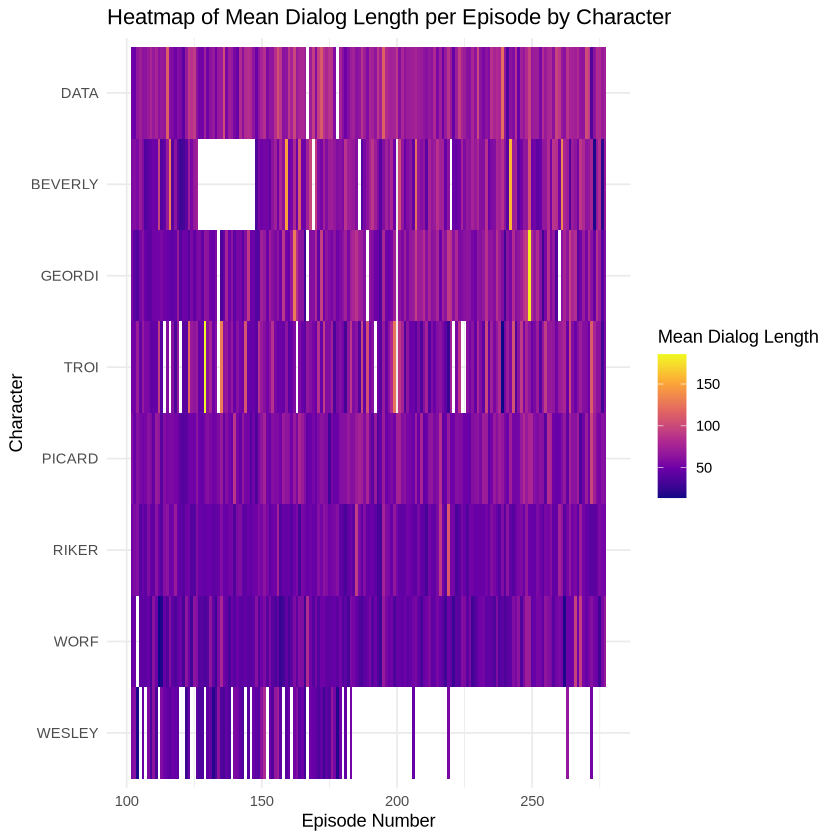

In [34]:
overall_means <- dialog_len_per_ep %>% group_by(
    character) %>% summarise(
    overall_mean = mean(mean_dialog_length), .groups = "drop") %>% arrange(
    overall_mean) %>% pull(
    character)

dialog_len_per_ep <- dialog_len_per_ep %>% mutate(
    character = factor(character, levels = overall_means))

library(ggplot2)
ggplot(dialog_len_per_ep, aes(x = episode_number, y = character,
                              fill = mean_dialog_length))+
geom_tile() + scale_fill_viridis_c(
    option = "plasma") +
labs(
    title = "Heatmap of Mean Dialog Length per Episode by Character",
    x = "Episode Number",
    y = "Character",
    fill = "Mean Dialog Length") + theme_minimal()